# Tutorial for R users

In this tutorial we will enrich Acropora digitifera observations with bathymetry information.
Please make sure you already followed the [installation instructions](https://geoenrich.readthedocs.io/en/latest/r-install.html).

We will first load the occurence file and create an *enrichment file*. As we download environment data, necessary metadata will be saved into that file.

Afterwards, we will pick a variable id from the [catalog](https://geoenrich.readthedocs.io/en/latest/variables.html), and start downloading bathymetry data.

Finally, we will visualize the result for one of the occurrences.

In [1]:
library(reticulate)

## Load your occurrence data

In [2]:
os <- import("os")
dataloader <- import("geoenrich.dataloader", convert=FALSE)
enrichment <- import("geoenrich.enrichment", convert=FALSE)

#### If you are using your own dataset (DarwinCore format)

A DarwinCore archive is bundled into the package for user testing (GBIF Occurrence Download [10.15468/dl.megb8n](https://doi.org/10.15468/dl.megb8n)).

If you don't have a dataset and you don't want to register to GBIF yet you can use this one.

In [3]:
example_path <- paste( os$path$split(dataloader$'__file__')[[1]],
                      '/data/AcDigitifera.zip', sep = '')
geodf <- dataloader$open_dwca(path = example_path)

#### If you are using your own dataset (csv format)

Fill in the path to your csv and the compulsory column names.

Additional arguments are passed down to pandas.read_csv

In [ ]:
geodf <- dataloader$import_occurrences_csv(path = '', id_col = '', date_col = '', lat_col = '',
                           lon_col = '', depth_col = '')

#### If you do not have occurrences but want to enrich arbitrary areas

See [documentation](https://geoenrich.readthedocs.io/en/latest/dataloader.html#geoenrich.dataloader.load_areas_file) for information about input file format.

In [4]:
example_path <- paste( os$path$split(dataloader$'__file__')[[1]] ,
                      '/data/areas.csv', sep = '')
df <- dataloader$load_areas_file(example_path)

#### Create enrichment file

In [5]:
# For occurrences
dataset_ref_occ <- 'ac_digitifera'
enrichment$create_enrichment_file(geodf, dataset_ref_occ)

In [ ]:
# For areas
dataset_ref_areas <- 'arbitrary_areas'
enrichment$create_enrichment_file(df, dataset_ref_areas)

## Enrich

#### Define enrichment scope

We use the dataset reference that was used to create the enrichment file.

geo_buff is the buffer around the occurences (in kilometers).

time_buff specifies a temporal buffer. In this case we download data from 7 days before the occurrence date, to the occurrence date. time_buff is only used for variables that have a time dimension

In [6]:
var_id <- 'bathymetry'
dataset_ref_occ <- 'ac_digitifera'
geo_buff <- 115
time_buff <- c(-7L, 0L)

#### Only enrich a small slice first to check speed.

In [7]:
enrichment$enrich(dataset_ref_occ, var_id, geo_buff,
                  time_buff, slice = c(0L,100L))

#### For large areas, use downsample argument to download only part of available data (to reduce download time)

In [ ]:
# Skip 9 latitude and longitude points for every downloaded point.
dataset_ref_areas <- 'arbitrary_areas'
downsample <- list('latitude'= 9L, 'longitude'= 9L)

enrichment$enrich(dataset_ref_areas, var_id, downsample = downsample)

## Data retrieval

In [8]:
exports <- import("geoenrich.exports")
enrichment <- import("geoenrich.enrichment", convert = FALSE)
dataset_ref <- 'ac_digitifera'
var_id <- 'bathymetry'

#### Check the enrichment status of the dataset.

In [ ]:
enrichment$enrichment_status(dataset_ref)

#### Export summary statistics to a csv file

In [9]:
exports$produce_stats(dataset_ref, var_id, out_path = './')

#### Export data as a png file for the first occurrence of the dataset

In [10]:
ids <- enrichment$read_ids(dataset_ref)
occ_id <- ids[[1]]

In [11]:
exports$export_png(dataset_ref, occ_id, var_id, path = '')

#### Retrieve the raw data and plot it

Required libraries: ggplot2, reshape2, wellknown, pals

In [12]:
library(ggplot2)
library(reshape2)
library(wellknown)
library(pals)

In [13]:
output <- exports$retrieve_data(dataset_ref, occ_id, var_id, shape = 'buffer')

data <- output$values
unit <- output$unit
coords <- output$coords

# Retrieve coordinates
for (c in coords){
    if (c[[1]] == 'latitude'){
        lats = c[[2]]}
    if (c[[1]] == 'longitude'){
        longs = c[[2]]}}

# Retrieve coordinates of the occurrence
occurrences <- read.csv(file = paste(enrichment$biodiv_path, dataset_ref,  '.csv', sep = ''), row.names = 1)
occ_point <- wkt2geojson(occurrences[as.character(occ_id),]$geometry)$geometry$coordinates

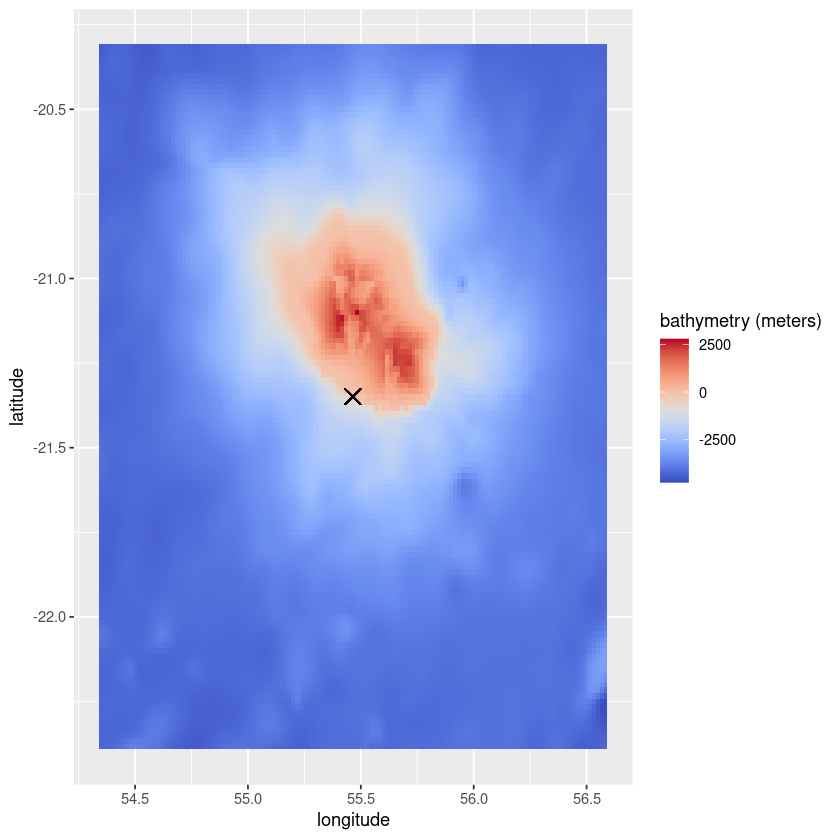

In [15]:
colnames(data) <- longs
rownames(data) <- lats
data_df <- melt(data)
colnames(data_df) <- c('latitude', 'longitude', var_id)
title <- paste(var_id, ' (', unit, ')', sep = '')
ggplot(data = data_df, aes(x=longitude, y=latitude, fill=eval(as.name(var_id)))) + 
       geom_tile()+
       scale_fill_gradientn(title,colours=coolwarm(100), guide = "colourbar")+
       geom_point(aes(x=occ_point[[1]], y=occ_point[[2]]), shape=4, size = 4)